# CFD for TOF

## Introduction

* Look at amplitude and timing distribution of first, second, third, etc pulses separately.

## Building a display

In [20]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from matplotlib import rc 
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [21]:
def load_waveform(event_number, root_file_path):
    
    branches = ["midas_data_D300", "midas_data_D301", "midas_data_D302", "midas_data_D303"]
    channels = [f"Channel{i}" for i in range(0,8)]
    waveforms = np.ndarray(shape=(8), dtype="object")
    ch_counter = 0
    
    with uproot.open(root_file_path) as root_file:
        for ch in channels:
            waveform_ch = root_file["midas_data_D301"].arrays([ch, "eventNumber"], library="np")
            
            if ch == "Channel0":
                waveform_index = np.where(waveform_ch["eventNumber"]==event_number)
                entry = waveform_index[0][0]
            
            waveforms[ch_counter] = waveform_ch[ch][entry]
            ch_counter += 1
    
    return waveforms

In [22]:
def load_information(event_number, npz_file_path):
    data = np.load(npz_file_path, allow_pickle=True)
    print("Looking for pulse information...")
    entry = np.where(data["event_number"]==event_number)[0][0]
    return data["count"][entry], data["baseline"][entry], data["CFD_timing"][entry], data["amplitude"][entry]

Loading the waveform and information. 
"%%timeit" measured 8.73 s $\pm$ 39.7 ms for this operation.

In [23]:
def plot_waveform(waveform, pulses=np.array([]), fmt='ro', title=''):
    
    # 14-bit @ 500 MS/s
    h_factor = 1./500.e6*1.e9
    sample = h_factor*np.arange(0, len(waveforms[0]))
    
    fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7)) = plt.subplots(nrows=2, ncols=4, sharey=False, sharex=True, figsize=(16,6))
    axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]
    
    for i in range(0, len(axes)):
        
        # Plot waveform
        axes[i].plot(sample, waveforms[i], "black")
        axes[i].set_xlim([sample[0],sample[-1]])
        axes[i].set_title(f"Ch. {i+8}")
        
        # Plot CFD timing
        if len(pulses) > 0:
            zeros = np.zeros(len(pulses[i]))
            for j in range(0, len(pulses[i])):
                axes[i].plot(pulses[i][j]*h_factor, zeros[j], fmt)

    # Axis labels
    ax0.set_ylabel("Amplitude (mV)")
    ax4.set_ylabel("Amplitude (mV)")
    for ax in axes[4:]: ax.set_xlabel("Time (ns)")
    plt.tight_layout()

## Running the Display

In [37]:
# Scale factors
h_factor = 1./500.e6*1.e9
v_factor = 1./16384.*2.*1.e3
event_number = 30
npz_file_path  = "../data/pulse_information-000435.npz"
count, baseline, timing_in, amplitude_in  = load_information(event_number, npz_file_path)
root_file_path = "../data/root_run_000435.root"
waveforms_in = load_waveform(event_number, root_file_path)

Looking for pulse information...


[array([ 34., 197.]), array([33.]), array([ 34., 136., 194.]), array([ 32., 166.]), array([ 40., 201.]), array([39.]), array([ 40., 196., 193.]), array([ 40.,  53.,  43.,  47.,  94., 182.])]


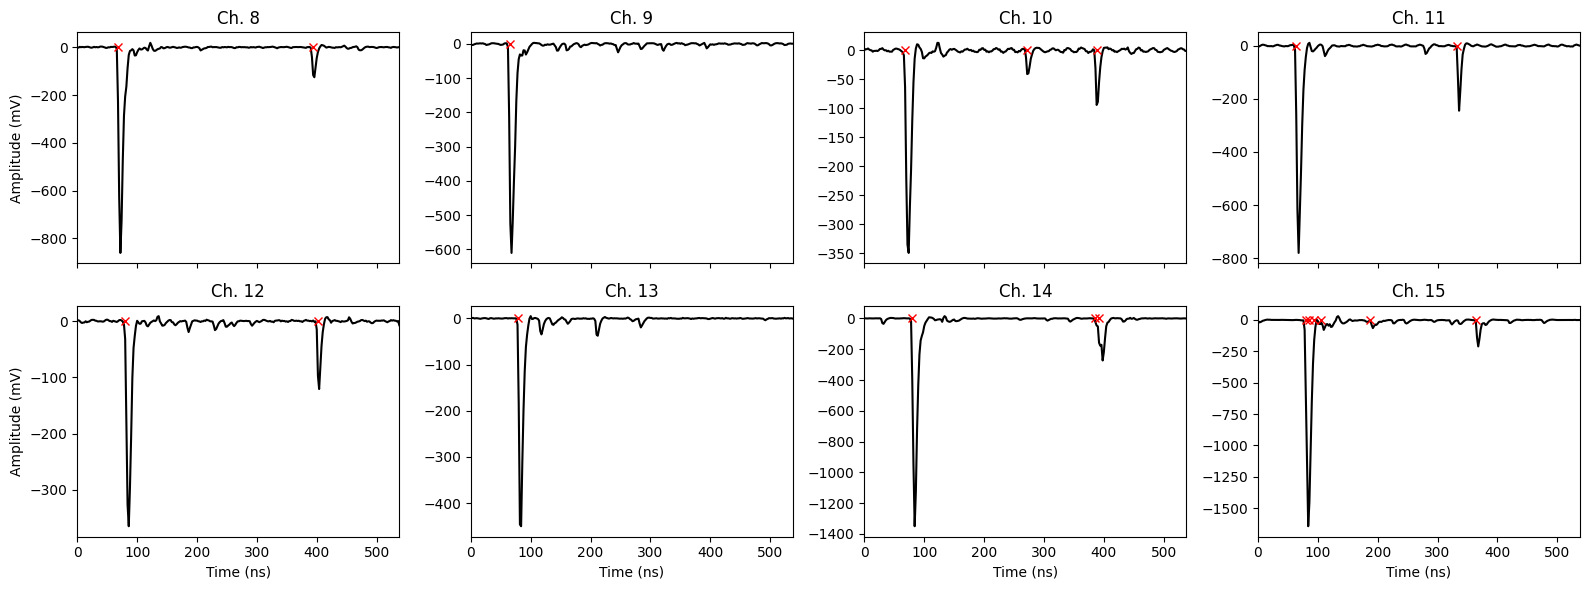

In [38]:
# Plot waveform
timing = timing_in
timing = [timing_in[i] for i in range(8,16)]
amplitude = [amplitude_in[i]*v_factor for i in range(8,16)]
waveforms = np.array([v_factor*(waveforms_in[i]-baseline[8+i]) for i in range(0,8)])
timing = [timing[i][abs(amplitude[i]) > 40] for i in range(0,8)]
plot_waveform(waveforms, timing, fmt='rx')

## Matching first and second highest of each waveform

Objetive: 

* Sort pulses in waveform by height.
* Find pulse timing average for each pulse order.
* Subtract average of TOF1 from TOF0.


In [64]:
def calculate_TOF(timing, amplitude, N):
    sorted_amps = [np.argsort(amplitude[i]) for i in range(0,8)]
    TOF_j = np.array([], dtype="float")
    for j in range(0, N):
        TOF0_j = np.average([timing[i][j] for i in range(0,4) if len(timing[i]) > j ])
        TOF1_j = np.average([timing[i][j] for i in range(4,8) if len(timing[i]) > j ])
        TOF_j  = np.append(TOF_j, [TOF1_j - TOF0_j], axis = None)
    return TOF_j
    

In [70]:
all_TOF = calculate_TOF(timing, amplitude, 2)
print(all_TOF)

[  6.5        -16.33333333]
